1. cell type 
2. coarse cell type

check elbo between wrong and correct ones

# Load packages

In [1]:
%cd ../RADOM

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

from inference import Trajectory
from plotting import *

/home/mffang/workspace/Poisson-regression/RADOM


In [2]:
import scanpy as sc
import scvelo as scv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Prepare input data

In [3]:
data_dir = "../data/Barile/"

## Load data

h5 files can be downloaded as following:
```
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_for_velocity_mouse.h5
#!wget --directory-prefix=../data/Barile/ http://bioinformatics.stemcells.cam.ac.uk/mb2338/adata_human_for_velocity.h5
```

In [4]:
data = sc.read(data_dir+'adata_for_velocity_mouse.h5')
gene_names = data.var_names
x = data.obsm['X_pca']
x[:,0] *= -1
data

AnnData object with n_obs × n_vars = 9815 × 3434
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [5]:
cell_types = ['Blood progenitors 1','Blood progenitors 2','Erythroid1','Erythroid2', 'Erythroid3']
stages = ['E7.0', 'E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25', 'E8.5']

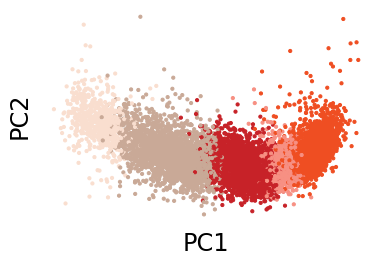

In [6]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=data.obs['colour'],s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [7]:
from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", data.uns['celltype_colors'], N=5)

# Murk genes

**Filter genes**

Because the unspliced counts are so low, the ratio of beta/gamma has to be very large. In such scenario, there is time scale seperation and phase plot looks like a (part of) rectangle.

In [8]:
murk_genes = list(pd.read_csv(data_dir+'murk_genes_mouse.txt',sep=" ",header=None)[0])
marker_genes = ["Gata1"]
fitted_genes_mask = (data.var_names.isin(murk_genes)) \
                    & (data.layers["unspliced"].toarray().mean(axis=0)>0.01) \
                    & (data.layers["spliced"].toarray().mean(axis=0)>0.01) \
                    & (np.abs(np.log10(data.layers["unspliced"].toarray().mean(axis=0)/data.layers["spliced"].toarray().mean(axis=0)))<=2) 
fitted_genes_mask = fitted_genes_mask | (data.var_names.isin(marker_genes))
fitted_genes = gene_names[fitted_genes_mask]
print(fitted_genes_mask.sum())

40


**Slice the count matrix and get X**

In [9]:
n,p = data[:,fitted_genes_mask].X.shape
X = np.zeros((n,p,2))
X[:,:,0]= data.layers["unspliced"].toarray()[:,fitted_genes_mask]
X[:,:,1]= data.layers["spliced"].toarray()[:,fitted_genes_mask]

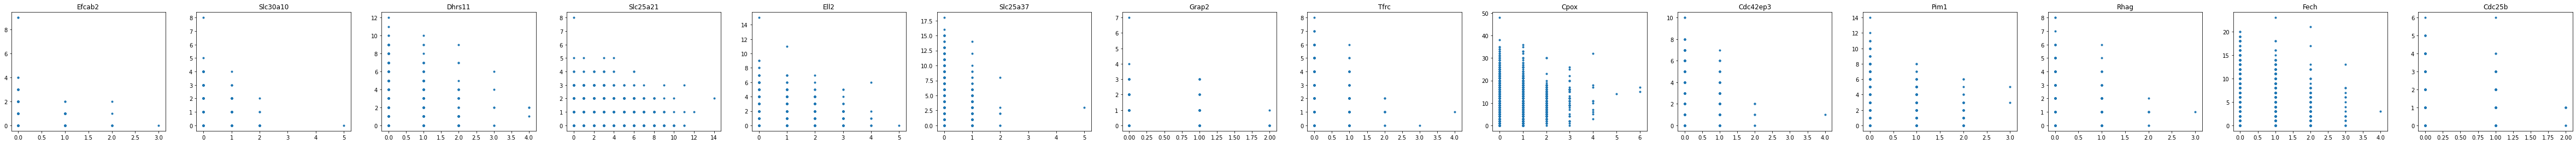

In [10]:
plot_p=14
fig, ax = plt.subplots(1,plot_p,figsize=(6*plot_p,4))
for j in range(plot_p):
    ax[j].plot(X[:,j,0],X[:,j,1],'.')
    ax[j].set_title(fitted_genes[j])

In [11]:
plot_genes = ['Smim1', 'Hba-x','Abcg2','Cnn3','Scube2']

In [12]:
plot_idx = [np.where(fitted_genes==gene)[0] for gene in plot_genes]
plot_idx = np.concatenate(plot_idx).ravel()
print(fitted_genes[plot_idx])

Index(['Smim1', 'Abcg2'], dtype='object', name='index')


In [13]:
elbos = {}

## Fine cluster

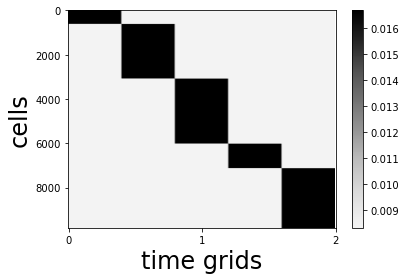

In [50]:
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
for i,cell_type in enumerate(cell_types):
    idx = data.obs["celltype"].isin([cell_type])
    weight0[idx,int(i*m/5):int((i+1)*m/5)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
ax = plot_t(Q0,order_cells=True)

x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)

label_font = '24'
plt.ylabel("cells", fontsize = label_font);
plt.xlabel("time grids", fontsize = label_font);

In [51]:
topo = np.array([[0,1]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,Q=Q0,parallel=True,n_threads=4,epoch=100)

run method fit_warm_start


 23%|██▎       | 23/100 [00:11<00:39,  1.93it/s]


In [52]:
elbos['cf'] = traj.elbos

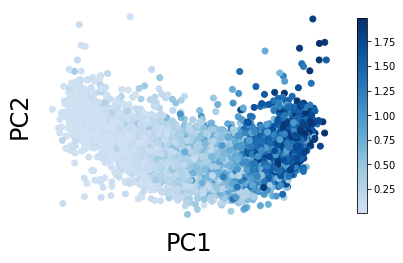

In [53]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

In [54]:
elbos['cc'] = traj.elbos

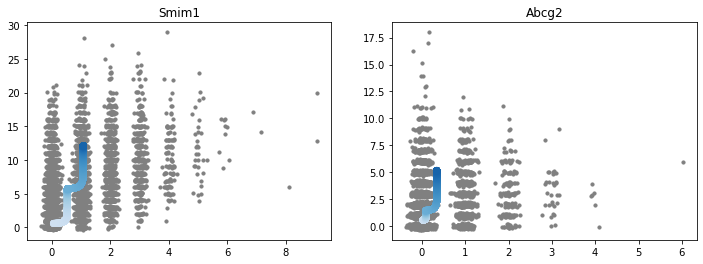

In [19]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

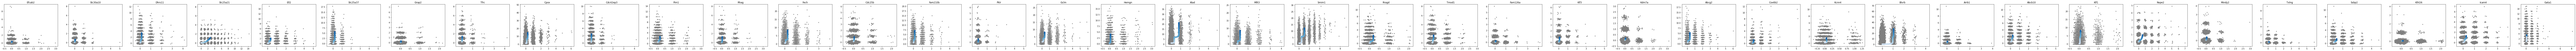

In [20]:
plot_phase(traj,idx=np.arange(len(fitted_genes)),gene_name=fitted_genes)

[]

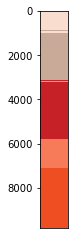

In [21]:
order = np.argsort(traj.Q[:,0]@traj.t)
cluster = np.zeros(data.n_obs)
for i,cell_type in enumerate(cell_types):
    idx = data.obs["celltype"].isin([cell_type])
    cluster[idx] = i
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
fig, ax = plt.subplots(1,1,figsize=(0.5,4))
ax.imshow(cluster[order,None],aspect="auto",cmap=cmap_cluster)
ax.set_xticks([])

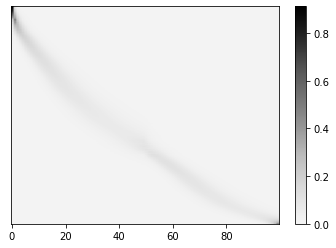

In [22]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj.Q[order],l=0,ax=ax,order_cells=False)
ax.set_yticks([]);

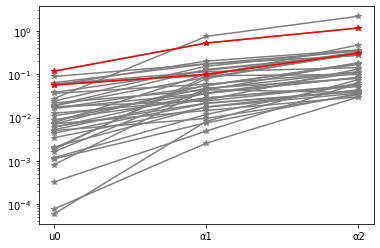

In [70]:
fig,ax = plt.subplots(1,1)
for j in range(p):
    ax.plot(traj.theta[j,[-3,0,1]],'-*',color='gray')
for j in plot_idx:
    ax.plot(traj.theta[j,[-3,0,1]],'-*',color='red')

x_label_list = ['u0', 'α1', 'α2']
ax.set_xticks([0,1,2])
ax.set_xticklabels(x_label_list)
plt.yscale('log')

## Fitting without prior

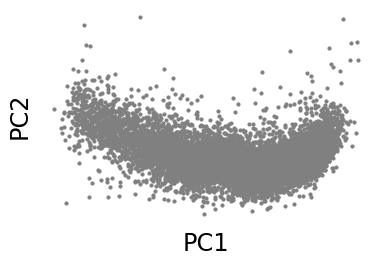

In [24]:
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c='grey',s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

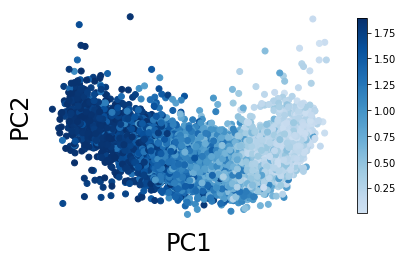

In [25]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2019)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2019'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

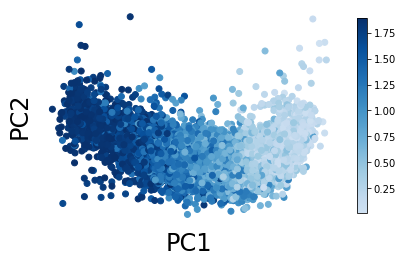

In [26]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2020)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2020'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

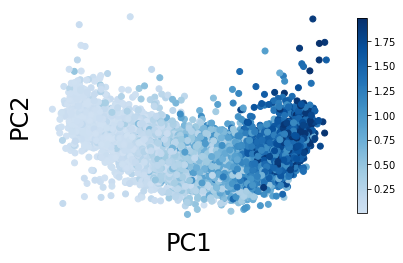

In [27]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2021)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2021'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

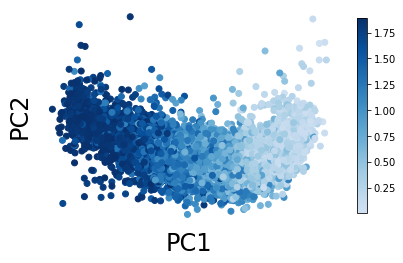

In [28]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2022)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2022'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

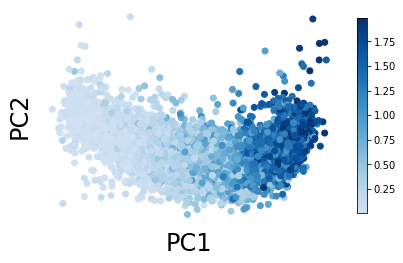

In [29]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2023)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2023'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

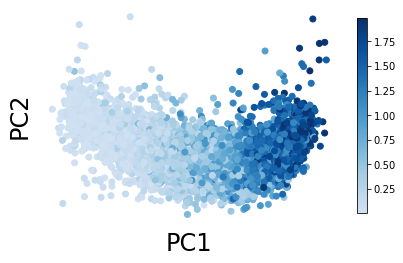

In [30]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=10,epoch=100,parallel=True,n_threads=4,seed=2024)

cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r2024'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

In [31]:
for idx in elbos.keys():
    print(idx, elbos[idx][-1])

cf 12.781922903968313
cc 12.781922903968313
r2019 13.620613049733045
r2020 13.62214705069256
r2021 13.633682568761074
r2022 13.617388217779844
r2023 13.635172803791267
r2024 13.634505813221091


In [43]:
topo = np.array([[0,1]])
tau = (0,1,2)
traj = Trajectory(topo, tau, model="two_species_ss",verbose=0)
traj = traj.fit(X,m=100,n_init=100,epoch=100,parallel=True,n_threads=4,seed=2023)

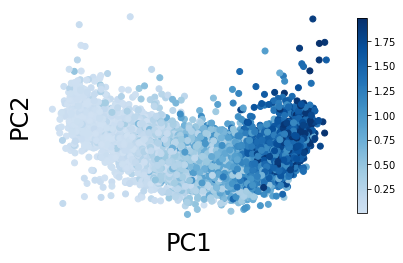

In [44]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

elbos['r'] = traj.elbos[np.argmax([traj.elbos[i][-1] for i in range(len(traj.elbos))])] 

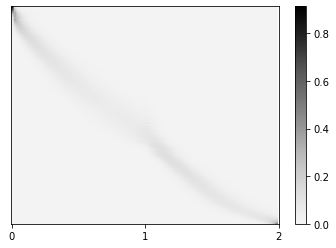

In [49]:
ax = plot_t(traj.Q[order],l=0,order_cells=False)
x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list);
ax.set_yticks([]);

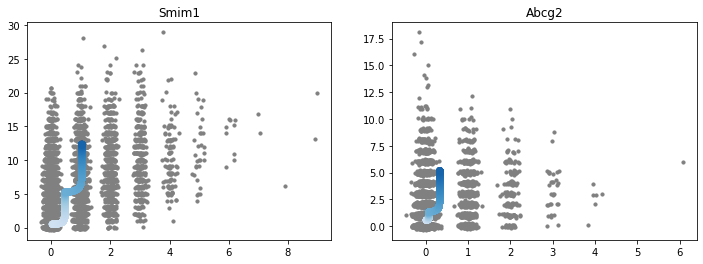

In [46]:
plot_phase(traj,idx=plot_idx,gene_name=fitted_genes)

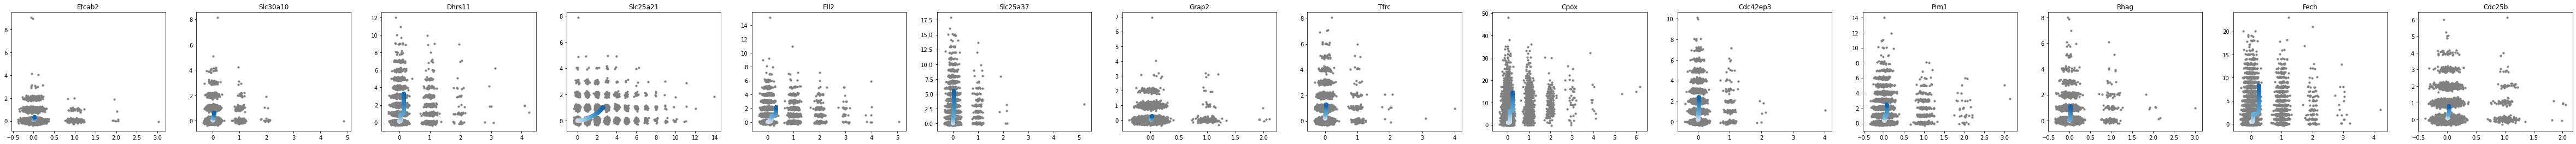

In [47]:
plot_phase(traj,idx=np.arange(14),gene_name=fitted_genes)

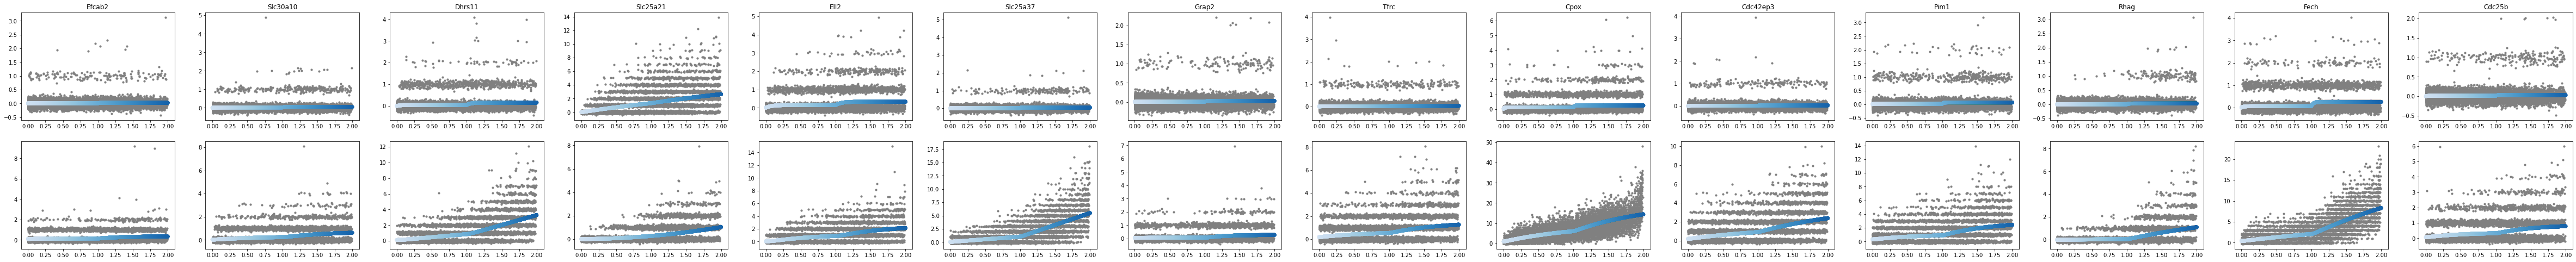

In [48]:
plot_y(traj,idx=np.arange(14),gene_name=fitted_genes)

In [38]:
#from scipy.spatial import distance

#S = data.X.toarray()
#dist = distance.cdist(S, S, 'minkowski', p=1.)

In [39]:
#order = np.argsort(data.obs["t_hat"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

In [40]:
#order = np.argsort(data.obs["celltype"])
#sorted_dist = dist[order,:][:,order]
#plt.imshow(sorted_dist,aspect="auto");

## Coarse clusters

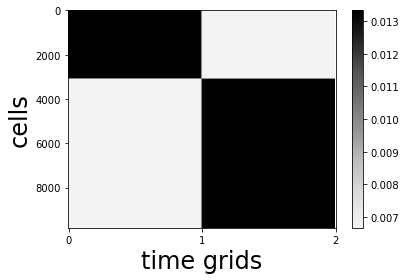

In [55]:
coarse_cell_types = [ ['Blood progenitors 1','Blood progenitors 2'],['Erythroid1','Erythroid2', 'Erythroid3']]
m=100
t_grids=np.linspace(0,2,m)
weight0 = np.ones((data.n_obs,m))
for i,cell_type in enumerate(coarse_cell_types):
    idx = data.obs["celltype"].isin(cell_type)
    weight0[idx,int(i*m/2):int((i+1)*m/2)] += 1
weight0=weight0/weight0.sum(axis=1,keepdims=True)
#plt.scatter(np.sum(t_grids[None,:]*weight0,axis=1),s,c=colors20[np.mod(clusters, 20)]);
Q0 = weight0[:,None]
ax = plot_t(Q0,order_cells=True)

x_label_list = ['0', '1', '2']
ax.set_xticks([0,50,100])
ax.set_xticklabels(x_label_list)

label_font = '24'
plt.ylabel("cells", fontsize = label_font);
plt.xlabel("time grids", fontsize = label_font);

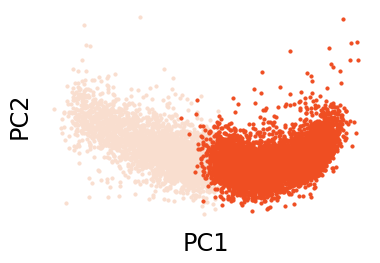

In [57]:
fig, ax = plt.subplots(1,1)
for i,celltype in enumerate(coarse_cell_types):
    idx = data.obs["celltype"].isin(celltype)
    im=ax.scatter(x[idx,0],x[idx,1],c=data.uns['celltype_colors'][4*i],s=10);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

In [58]:
topo = np.array([[0,1]])
tau = (0,1,2) # ~48 hours
traj = Trajectory(topo, tau, model="two_species_ss",verbose=1)
traj = traj.fit(X,Q=Q0,parallel=True,n_threads=4,epoch=100)

run method fit_warm_start


 31%|███       | 31/100 [00:14<00:33,  2.07it/s]


In [59]:
elbos['cc'] = traj.elbos

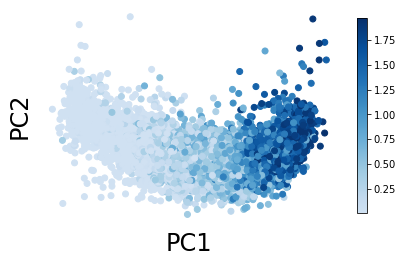

In [60]:
cmap_y = cmr.get_sub_cmap('Blues', 0.2, 1)
fig, ax = plt.subplots(1,1)
im=ax.scatter(x[:,0],x[:,1],c=traj.Q[:,0]@traj.t,cmap=cmap_y);
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);
plt.colorbar(im,fraction=0.05, shrink =0.9) # adding the colobar on the right

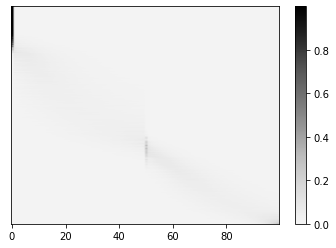

In [61]:
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax=plot_t(traj.Q[order],l=0,ax=ax,order_cells=False)
ax.set_yticks([]);

In [ ]:
plot_y(traj,idx=np.arange(14),gene_name=fitted_genes)

In [ ]:
plot_phase(traj,idx=np.arange(14),gene_name=fitted_genes)

In [ ]:
plot_mask = fitted_genes.isin(their_genes)
plot_idx = np.arange(len(fitted_genes))[plot_mask]

plot_phase(traj, plot_idx, gene_list, cell_colors='grey')

plot_y(traj, plot_idx, gene_list, cell_colors='grey')

## ELBO plot

In [67]:
for idx in elbos.keys():
    print(idx, np.around(elbos[idx][-1],4))

cf 12.7819
cc 12.192
r2019 13.6206
r2020 13.6221
r2021 13.6337
r2022 13.6174
r2023 13.6352
r2024 13.6345
r 13.6441


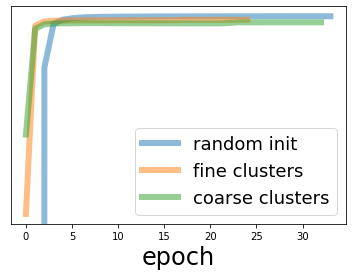

In [62]:
fig, ax = plt.subplots(1,1)
ax.plot(elbos['r'],label="random init",linewidth=6,alpha=0.5);
ax.plot(elbos['cf'],label="fine clusters",linewidth=6,alpha=0.5);
ax.plot(elbos['cc'],label="coarse clusters",linewidth=6,alpha=0.5);
ax.set_yscale('log')
ax.set_xlabel('epoch',fontsize=24)
ax.set_ylabel('relative elbo',fontsize=24)
plt.legend(fontsize=18);
ax.axes.get_yaxis().set_visible(False)